# Susceptibility to substitution

## 1 Setup

Flags and settings.

In [1]:
SAVE_FIGURES = False
PAPER_FEATURES = ['frequency', 'aoa', 'clustering', 'letters_count',
                  'synonyms_count', 'orthographic_density']
BIN_COUNT = 4

Imports and database setup.

In [2]:
import pandas as pd
import seaborn as sb
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from progressbar import ProgressBar
from statsmodels.stats.proportion import multinomial_proportions_confint

%cd -q ..
from brainscopypaste.conf import settings
%cd -q notebooks
from brainscopypaste.mine import Model, Time, Source, Past, Durl
from brainscopypaste.db import Substitution
from brainscopypaste.utils import init_db, session_scope, stopwords
engine = init_db()

Build our data.

In [3]:
def qposition(values, position):
    value = values[position]
    if np.isnan(value):
        return np.nan, np.nan
    finite_values = values[np.isfinite(values)]
    svalues = np.array(sorted(finite_values))
    length = len(svalues)
    ours = np.where(svalues == value)[0]
    return ours[0] / length, (ours[-1] + 1) / length

In [4]:
model = Model(time=Time.discrete, source=Source.majority, past=Past.all, durl=Durl.all, max_distance=1)
stop_poses = ['C', 'F', 'I', 'M', 'P', 'S', 'U']

data = []

# First get the exact substitution ids so we can get a working progress bar
# in the next step.
with session_scope() as session:
    substitutions = session.query(Substitution.id)\
        .filter(Substitution.model == model)
    print("Got {} substitutions for model {}"
          .format(substitutions.count(), model))
    substitution_ids = [id for (id,) in substitutions]

for substitution_id in ProgressBar(term_width=80)(substitution_ids):
    with session_scope() as session:
        substitution = session.query(Substitution).get(substitution_id)
        
        # Prepare these arrays for use in stopword-checking.
        dslice = slice(substitution.start,
                       substitution.start
                       + len(substitution.destination.tokens))
        lemmas = substitution.source.lemmas[dslice]
        tokens = substitution.source.tokens[dslice]
        tags = substitution.source.tags[dslice]
        is_stopword = np.array([(lemma in stopwords)
                                or (token in stopwords)
                                for (lemma, token) in zip(lemmas, tokens)])
        
        for feature in Substitution.__features__:
            
            # Get feature values for the sentence and its words.
            sentence_values, _ = substitution.\
                source_destination_features(feature)
            sentence_values_rel, _ = substitution.\
                source_destination_features(feature,
                                            sentence_relative='median')
            source_type, _ = Substitution.__features__[feature]
            words = getattr(substitution.source, source_type)[dslice]
            
            # Find the bins we'll use.
            # If there are only NaNs or only one feature value
            # we can't get bins on this sentence, so we want at least
            # 2 different feature values.
            # We also skip feature values if the source word is not coded
            # for the feature, as it would skew the 'appeared' 
            # distributions compared to the distribution of substituted
            # words. (For instance, the sum of categories would not be 
            # equal to the sum of H0s in the very last graphs, 
            # on sentencequantile. It also lets us make meaningful H0
            # comparison in all the other feature-based graphs.)
            non_sw_values = sentence_values.copy()
            non_sw_values[is_stopword] = np.nan
            non_sw_value_set = \
                set(non_sw_values[np.isfinite(non_sw_values)])
            if (len(non_sw_value_set) <= 1 or
                    np.isnan(sentence_values[substitution.position])):
                allnans = [np.nan] * len(non_sw_values)
                bins = allnans
                non_sw_values = allnans
                sentence_values = allnans
                sentence_values_rel = allnans
            else:
                bins = pd.cut(non_sw_values, BIN_COUNT, labels=False)
            
            # For each non-stopword, store its various properties.
            for i, (word, tag, skip) in enumerate(zip(words, tags,
                                                      is_stopword)):
                if skip:
                    # Drop any stopwords.
                    continue

                # Get a readable POS tag
                rtag = tag[0]
                rtag = 'Stopword-like' if rtag in stop_poses else rtag
                
                # Get the word's quantile position.
                start_quantile, stop_quantile = qposition(non_sw_values, i)

                # Store the word's properties.
                data.append({
                    'cluster_id': substitution.source.cluster.sid,
                    'destination_id': substitution.destination.sid,
                    'occurrence': substitution.occurrence,
                    'source_id': substitution.source.sid,
                    'position': substitution.position,
                    'feature': feature,
                    'word': word,
                    'POS': tag,
                    'rPOS': rtag,
                    'target': i == substitution.position,
                    'value': sentence_values[i],
                    'value_rel': sentence_values_rel[i],
                    'bin': bins[i],
                    'start_quantile': start_quantile,
                    'stop_quantile': stop_quantile,
                    'word_position': i
                })

words = pd.DataFrame(data)
del data

Got 14308 substitutions for model Model(time=Time.discrete, source=Source.majority, past=Past.all, durl=Durl.all, max_distance=1)


  0% (    1 of 14308) |                   | Elapsed Time: 0:00:03 ETA:  15:13:42

  0% (   64 of 14308) |                    | Elapsed Time: 0:00:04 ETA:  0:03:44

  0% (  135 of 14308) |                    | Elapsed Time: 0:00:05 ETA:  0:03:29

  1% (  179 of 14308) |                    | Elapsed Time: 0:00:06 ETA:  0:03:24

  1% (  268 of 14308) |                    | Elapsed Time: 0:00:07 ETA:  0:03:07

  2% (  358 of 14308) |                    | Elapsed Time: 0:00:08 ETA:  0:02:58

  3% (  441 of 14308) |                    | Elapsed Time: 0:00:09 ETA:  0:02:55

  3% (  537 of 14308) |                    | Elapsed Time: 0:00:10 ETA:  0:02:51

  4% (  615 of 14308) |                    | Elapsed Time: 0:00:11 ETA:  0:02:45

  4% (  694 of 14308) |                    | Elapsed Time: 0:00:12 ETA:  0:02:41

  5% (  716 of 14308) |#                   | Elapsed Time: 0:00:12 ETA:  0:02:40

  5% (  797 of 14308) |#                   | Elapsed Time: 0:00:13 ETA:  0:02:41

  6% (  895 of 14308) |#                   | Elapsed Time: 0:00:15 ETA:  0:02:42

  6% (  976 of 14308) |#                   | Elapsed Time: 0:00:16 ETA:  0:02:41

  7% ( 1050 of 14308) |#                   | Elapsed Time: 0:00:17 ETA:  0:02:44

  7% ( 1074 of 14308) |#                   | Elapsed Time: 0:00:17 ETA:  0:02:45

  8% ( 1157 of 14308) |#                   | Elapsed Time: 0:00:18 ETA:  0:02:42

  8% ( 1252 of 14308) |#                   | Elapsed Time: 0:00:19 ETA:  0:02:37

  9% ( 1343 of 14308) |#                   | Elapsed Time: 0:00:20 ETA:  0:02:32

  9% ( 1405 of 14308) |#                   | Elapsed Time: 0:00:21 ETA:  0:02:42

 10% ( 1431 of 14308) |##                  | Elapsed Time: 0:00:22 ETA:  0:02:42

 10% ( 1513 of 14308) |##                  | Elapsed Time: 0:00:23 ETA:  0:02:41

 11% ( 1610 of 14308) |##                  | Elapsed Time: 0:00:24 ETA:  0:02:33

 11% ( 1676 of 14308) |##                  | Elapsed Time: 0:00:25 ETA:  0:02:37

 12% ( 1757 of 14308) |##                  | Elapsed Time: 0:00:26 ETA:  0:02:40

 12% ( 1789 of 14308) |##                  | Elapsed Time: 0:00:26 ETA:  0:02:43

 13% ( 1864 of 14308) |##                  | Elapsed Time: 0:00:27 ETA:  0:02:48

 13% ( 1949 of 14308) |##                  | Elapsed Time: 0:00:28 ETA:  0:02:35

 13% ( 1968 of 14308) |##                  | Elapsed Time: 0:00:28 ETA:  0:02:33

 14% ( 2047 of 14308) |##                  | Elapsed Time: 0:00:29 ETA:  0:02:33

 14% ( 2123 of 14308) |##                  | Elapsed Time: 0:00:30 ETA:  0:02:37

 15% ( 2147 of 14308) |###                 | Elapsed Time: 0:00:31 ETA:  0:02:38

 15% ( 2246 of 14308) |###                 | Elapsed Time: 0:00:32 ETA:  0:02:26

 16% ( 2326 of 14308) |###                 | Elapsed Time: 0:00:33 ETA:  0:02:23

 16% ( 2411 of 14308) |###                 | Elapsed Time: 0:00:34 ETA:  0:02:18

 17% ( 2504 of 14308) |###                 | Elapsed Time: 0:00:35 ETA:  0:02:15

 18% ( 2590 of 14308) |###                 | Elapsed Time: 0:00:36 ETA:  0:02:13

 18% ( 2667 of 14308) |###                 | Elapsed Time: 0:00:37 ETA:  0:02:13

 18% ( 2683 of 14308) |###                 | Elapsed Time: 0:00:37 ETA:  0:02:11

 19% ( 2763 of 14308) |###                 | Elapsed Time: 0:00:38 ETA:  0:02:11

 19% ( 2820 of 14308) |###                 | Elapsed Time: 0:00:39 ETA:  0:02:22

 20% ( 2862 of 14308) |####                | Elapsed Time: 0:00:40 ETA:  0:02:30

 20% ( 2932 of 14308) |####                | Elapsed Time: 0:00:41 ETA:  0:02:34

 20% ( 2996 of 14308) |####                | Elapsed Time: 0:00:42 ETA:  0:02:41

 21% ( 3041 of 14308) |####                | Elapsed Time: 0:00:42 ETA:  0:02:40

 21% ( 3118 of 14308) |####                | Elapsed Time: 0:00:43 ETA:  0:02:42

 22% ( 3179 of 14308) |####                | Elapsed Time: 0:00:45 ETA:  0:02:54

 22% ( 3220 of 14308) |####                | Elapsed Time: 0:00:45 ETA:  0:02:53

 23% ( 3311 of 14308) |####                | Elapsed Time: 0:00:46 ETA:  0:02:48

 23% ( 3399 of 14308) |####                | Elapsed Time: 0:00:47 ETA:  0:02:34

 24% ( 3486 of 14308) |####                | Elapsed Time: 0:00:48 ETA:  0:02:24

 25% ( 3577 of 14308) |#####               | Elapsed Time: 0:00:49 ETA:  0:02:16

 25% ( 3673 of 14308) |#####               | Elapsed Time: 0:00:50 ETA:  0:02:06

 26% ( 3756 of 14308) |#####               | Elapsed Time: 0:00:51 ETA:  0:02:02

 26% ( 3835 of 14308) |#####               | Elapsed Time: 0:00:52 ETA:  0:02:01

 27% ( 3889 of 14308) |#####               | Elapsed Time: 0:00:53 ETA:  0:01:58

 27% ( 3935 of 14308) |#####               | Elapsed Time: 0:00:54 ETA:  0:01:57

 28% ( 4023 of 14308) |#####               | Elapsed Time: 0:00:55 ETA:  0:01:57

 28% ( 4097 of 14308) |#####               | Elapsed Time: 0:00:56 ETA:  0:02:00

 28% ( 4114 of 14308) |#####               | Elapsed Time: 0:00:56 ETA:  0:02:02

 29% ( 4204 of 14308) |#####               | Elapsed Time: 0:00:57 ETA:  0:02:02

 30% ( 4293 of 14308) |######              | Elapsed Time: 0:00:58 ETA:  0:02:02

 30% ( 4374 of 14308) |######              | Elapsed Time: 0:00:59 ETA:  0:02:03

 31% ( 4472 of 14308) |######              | Elapsed Time: 0:01:00 ETA:  0:01:52

 31% ( 4556 of 14308) |######              | Elapsed Time: 0:01:01 ETA:  0:01:48

 32% ( 4651 of 14308) |######              | Elapsed Time: 0:01:02 ETA:  0:01:46

 33% ( 4741 of 14308) |######              | Elapsed Time: 0:01:03 ETA:  0:01:43

 33% ( 4829 of 14308) |######              | Elapsed Time: 0:01:04 ETA:  0:01:41

 34% ( 4916 of 14308) |######              | Elapsed Time: 0:01:05 ETA:  0:01:42

 35% ( 5008 of 14308) |#######             | Elapsed Time: 0:01:06 ETA:  0:01:37

 35% ( 5081 of 14308) |#######             | Elapsed Time: 0:01:07 ETA:  0:01:40

 36% ( 5153 of 14308) |#######             | Elapsed Time: 0:01:08 ETA:  0:01:42

 36% ( 5187 of 14308) |#######             | Elapsed Time: 0:01:09 ETA:  0:01:39

 36% ( 5273 of 14308) |#######             | Elapsed Time: 0:01:10 ETA:  0:01:38

 37% ( 5340 of 14308) |#######             | Elapsed Time: 0:01:11 ETA:  0:01:44

 37% ( 5366 of 14308) |#######             | Elapsed Time: 0:01:11 ETA:  0:01:47

 38% ( 5448 of 14308) |#######             | Elapsed Time: 0:01:12 ETA:  0:01:48

 38% ( 5545 of 14308) |#######             | Elapsed Time: 0:01:13 ETA:  0:01:48

 39% ( 5630 of 14308) |#######             | Elapsed Time: 0:01:14 ETA:  0:01:44

 40% ( 5724 of 14308) |########            | Elapsed Time: 0:01:15 ETA:  0:01:39

 40% ( 5774 of 14308) |########            | Elapsed Time: 0:01:16 ETA:  0:01:51

 41% ( 5878 of 14308) |########            | Elapsed Time: 0:01:17 ETA:  0:01:37

 41% ( 5903 of 14308) |########            | Elapsed Time: 0:01:18 ETA:  0:01:37

 41% ( 5992 of 14308) |########            | Elapsed Time: 0:01:19 ETA:  0:01:34

 42% ( 6081 of 14308) |########            | Elapsed Time: 0:01:20 ETA:  0:01:30

 43% ( 6175 of 14308) |########            | Elapsed Time: 0:01:21 ETA:  0:01:27

 43% ( 6260 of 14308) |########            | Elapsed Time: 0:01:22 ETA:  0:01:23

 44% ( 6346 of 14308) |########            | Elapsed Time: 0:01:23 ETA:  0:01:22

 45% ( 6439 of 14308) |#########           | Elapsed Time: 0:01:24 ETA:  0:01:11

 45% ( 6518 of 14308) |#########           | Elapsed Time: 0:01:25 ETA:  0:01:16

 46% ( 6618 of 14308) |#########           | Elapsed Time: 0:01:26 ETA:  0:01:14

 46% ( 6712 of 14308) |#########           | Elapsed Time: 0:01:27 ETA:  0:01:12

 47% ( 6797 of 14308) |#########           | Elapsed Time: 0:01:28 ETA:  0:01:13

 48% ( 6878 of 14308) |#########           | Elapsed Time: 0:01:29 ETA:  0:01:16

 48% ( 6976 of 14308) |#########           | Elapsed Time: 0:01:30 ETA:  0:01:14

 49% ( 7062 of 14308) |#########           | Elapsed Time: 0:01:31 ETA:  0:01:13

 50% ( 7154 of 14308) |##########          | Elapsed Time: 0:01:32 ETA:  0:01:10

 50% ( 7237 of 14308) |##########          | Elapsed Time: 0:01:33 ETA:  0:01:10

 51% ( 7309 of 14308) |##########          | Elapsed Time: 0:01:34 ETA:  0:01:15

 51% ( 7333 of 14308) |##########          | Elapsed Time: 0:01:34 ETA:  0:01:16

 51% ( 7425 of 14308) |##########          | Elapsed Time: 0:01:35 ETA:  0:01:11

 52% ( 7512 of 14308) |##########          | Elapsed Time: 0:01:36 ETA:  0:01:15

 53% ( 7608 of 14308) |##########          | Elapsed Time: 0:01:37 ETA:  0:01:11

 53% ( 7691 of 14308) |##########          | Elapsed Time: 0:01:38 ETA:  0:01:11

 54% ( 7786 of 14308) |##########          | Elapsed Time: 0:01:39 ETA:  0:01:07

 55% ( 7870 of 14308) |###########         | Elapsed Time: 0:01:40 ETA:  0:01:05

 55% ( 7959 of 14308) |###########         | Elapsed Time: 0:01:41 ETA:  0:01:00

 56% ( 8049 of 14308) |###########         | Elapsed Time: 0:01:42 ETA:  0:00:57

 56% ( 8129 of 14308) |###########         | Elapsed Time: 0:01:43 ETA:  0:00:58

 57% ( 8228 of 14308) |###########         | Elapsed Time: 0:01:44 ETA:  0:00:54

 58% ( 8314 of 14308) |###########         | Elapsed Time: 0:01:45 ETA:  0:00:55

 58% ( 8406 of 14308) |###########         | Elapsed Time: 0:01:46 ETA:  0:00:57

 59% ( 8490 of 14308) |###########         | Elapsed Time: 0:01:47 ETA:  0:00:57

 60% ( 8585 of 14308) |############        | Elapsed Time: 0:01:49 ETA:  0:01:01

 60% ( 8667 of 14308) |############        | Elapsed Time: 0:01:50 ETA:  0:01:00

 61% ( 8764 of 14308) |############        | Elapsed Time: 0:01:51 ETA:  0:00:59

 61% ( 8835 of 14308) |############        | Elapsed Time: 0:01:52 ETA:  0:01:12

 62% ( 8943 of 14308) |############        | Elapsed Time: 0:01:53 ETA:  0:01:07

 63% ( 9036 of 14308) |############        | Elapsed Time: 0:01:54 ETA:  0:01:03

 63% ( 9122 of 14308) |############        | Elapsed Time: 0:01:55 ETA:  0:00:59

 64% ( 9211 of 14308) |############        | Elapsed Time: 0:01:56 ETA:  0:00:56

 65% ( 9301 of 14308) |#############       | Elapsed Time: 0:01:57 ETA:  0:00:55

 65% ( 9400 of 14308) |#############       | Elapsed Time: 0:01:58 ETA:  0:00:50

 66% ( 9480 of 14308) |#############       | Elapsed Time: 0:01:59 ETA:  0:00:38

 66% ( 9563 of 14308) |#############       | Elapsed Time: 0:02:00 ETA:  0:00:39

 67% ( 9658 of 14308) |#############       | Elapsed Time: 0:02:01 ETA:  0:00:39

 68% ( 9747 of 14308) |#############       | Elapsed Time: 0:02:02 ETA:  0:00:38

 68% ( 9837 of 14308) |#############       | Elapsed Time: 0:02:03 ETA:  0:00:40

 69% ( 9914 of 14308) |#############       | Elapsed Time: 0:02:04 ETA:  0:00:42

 70% (10016 of 14308) |##############      | Elapsed Time: 0:02:05 ETA:  0:00:41

 70% (10105 of 14308) |##############      | Elapsed Time: 0:02:06 ETA:  0:00:38

 71% (10195 of 14308) |##############      | Elapsed Time: 0:02:07 ETA:  0:00:39

 71% (10278 of 14308) |##############      | Elapsed Time: 0:02:08 ETA:  0:00:40

 72% (10374 of 14308) |##############      | Elapsed Time: 0:02:10 ETA:  0:00:37

 73% (10453 of 14308) |##############      | Elapsed Time: 0:02:11 ETA:  0:00:35

 73% (10540 of 14308) |##############      | Elapsed Time: 0:02:12 ETA:  0:00:37

 73% (10553 of 14308) |##############      | Elapsed Time: 0:02:12 ETA:  0:00:41

 74% (10605 of 14308) |##############      | Elapsed Time: 0:02:13 ETA:  0:00:53

 74% (10692 of 14308) |##############      | Elapsed Time: 0:02:14 ETA:  0:00:51

 75% (10731 of 14308) |###############     | Elapsed Time: 0:02:14 ETA:  0:00:50

 75% (10824 of 14308) |###############     | Elapsed Time: 0:02:15 ETA:  0:00:46

 76% (10910 of 14308) |###############     | Elapsed Time: 0:02:16 ETA:  0:00:45

 76% (10996 of 14308) |###############     | Elapsed Time: 0:02:17 ETA:  0:00:42

 77% (11089 of 14308) |###############     | Elapsed Time: 0:02:18 ETA:  0:00:36

 78% (11179 of 14308) |###############     | Elapsed Time: 0:02:19 ETA:  0:00:23

 78% (11268 of 14308) |###############     | Elapsed Time: 0:02:20 ETA:  0:00:20

 79% (11357 of 14308) |###############     | Elapsed Time: 0:02:21 ETA:  0:00:18

 80% (11447 of 14308) |################    | Elapsed Time: 0:02:22 ETA:  0:00:17

 80% (11530 of 14308) |################    | Elapsed Time: 0:02:23 ETA:  0:00:18

 81% (11626 of 14308) |################    | Elapsed Time: 0:02:25 ETA:  0:00:17

 81% (11715 of 14308) |################    | Elapsed Time: 0:02:26 ETA:  0:00:16

 82% (11805 of 14308) |################    | Elapsed Time: 0:02:27 ETA:  0:00:14

 83% (11893 of 14308) |################    | Elapsed Time: 0:02:28 ETA:  0:00:15

 83% (11983 of 14308) |################    | Elapsed Time: 0:02:29 ETA:  0:00:16

 84% (12067 of 14308) |################    | Elapsed Time: 0:02:30 ETA:  0:00:15

 85% (12162 of 14308) |#################   | Elapsed Time: 0:02:31 ETA:  0:00:13

 85% (12243 of 14308) |#################   | Elapsed Time: 0:02:32 ETA:  0:00:14

 86% (12341 of 14308) |#################   | Elapsed Time: 0:02:33 ETA:  0:00:14

 86% (12433 of 14308) |#################   | Elapsed Time: 0:02:34 ETA:  0:00:12

 87% (12520 of 14308) |#################   | Elapsed Time: 0:02:35 ETA:  0:00:08

 87% (12548 of 14308) |#################   | Elapsed Time: 0:02:36 ETA:  0:00:25

 88% (12634 of 14308) |#################   | Elapsed Time: 0:02:37 ETA:  0:00:23

 88% (12699 of 14308) |#################   | Elapsed Time: 0:02:37 ETA:  0:00:20

 89% (12783 of 14308) |#################   | Elapsed Time: 0:02:38 ETA:  0:00:18

 90% (12878 of 14308) |##################  | Elapsed Time: 0:02:40 ETA:  0:00:19

 90% (12968 of 14308) |##################  | Elapsed Time: 0:02:41 ETA:  0:00:15

 91% (13030 of 14308) |##################  | Elapsed Time: 0:02:42 ETA:  0:00:23

 91% (13057 of 14308) |##################  | Elapsed Time: 0:02:42 ETA:  0:00:27

 91% (13146 of 14308) |##################  | Elapsed Time: 0:02:43 ETA:  0:00:07

 92% (13235 of 14308) |##################  | Elapsed Time: 0:02:44 ETA:  0:00:04

 93% (13318 of 14308) |##################  | Elapsed Time: 0:02:45 ETA:  0:00:06

 93% (13414 of 14308) |##################  | Elapsed Time: 0:02:46 ETA:  0:00:06

 94% (13496 of 14308) |##################  | Elapsed Time: 0:02:47 ETA:  0:00:05

 95% (13593 of 14308) |################### | Elapsed Time: 0:02:48 ETA:  0:00:00

 95% (13666 of 14308) |################### | Elapsed Time: 0:02:49 ETA:  0:00:03

 96% (13751 of 14308) |################### | Elapsed Time: 0:02:50 ETA:  0:00:03

 96% (13772 of 14308) |################### | Elapsed Time: 0:02:51 ETA:  0:00:05

 96% (13862 of 14308) |################### | Elapsed Time: 0:02:52 ETA:  0:00:02

 97% (13951 of 14308) |################### | Elapsed Time: 0:02:53 ETA:  0:00:00

 98% (14028 of 14308) |################### | Elapsed Time: 0:02:54 ETA:  0:00:00

 98% (14130 of 14308) |################### | Elapsed Time: 0:02:55 ETA:  0:00:00

 99% (14217 of 14308) |################### | Elapsed Time: 0:02:56 ETA:  0:00:00

 99% (14290 of 14308) |################### | Elapsed Time: 0:02:57 ETA:  0:00:00

100% (14308 of 14308) |####################| Elapsed Time: 0:02:57 Time: 0:02:57


Assign proper weight to each substitution.

In [5]:
divide_target_all_sum = \
    lambda x: x / (words.loc[x.index].target 
                   * words.loc[x.index].weight_all).sum()
divide_target_feature_sum = \
    lambda x: x / (words.loc[x.index].target 
                   * words.loc[x.index].weight_feature).sum()

# Weight is 1, at first (or 1 for feature-coded substitutions).
words['weight_all'] = 1
words['weight_feature'] = 1 * np.isfinite(words.value)

# Divided by the number of substitutions that share a durl.
print('Computing shared durl (all) weights')
words['weight_all'] = words\
    .groupby(['destination_id', 'occurrence', 'position',
              'feature'])['weight_all']\
    .transform(divide_target_all_sum)
print('Computing shared durl (per-feature) weights')
words['weight_feature'] = words\
    .groupby(['destination_id', 'occurrence', 'position',
              'feature'])['weight_feature']\
    .transform(divide_target_feature_sum)

# Divided by the number of substitutions that share a cluster.
# (Using divide_target_sum, where we divide by the sum of weights,
# ensures we count only one for each group of substitutions sharing
# a same durl.)
print('Computing shared cluster (all) weights')
words['weight_all'] = words\
    .groupby(['cluster_id', 'feature'])['weight_all']\
    .transform(divide_target_all_sum)
print('Computing shared cluster (per-feature) weights')
words['weight_feature'] = words\
    .groupby(['cluster_id', 'feature'])['weight_feature']\
    .transform(divide_target_feature_sum)

# Add a weight measure for word appearances, weighing a word
# by the number of words that appear with it in its sentence.
# And the same for substitutions *whose source is coded by the feature*.
# (This lets us have the sum of categories equal the sum of H0s
# in the very last graphs [on sentencequantile], and make meaningful H0
# comparison values for all the other feature-based graphs.)
print('Computing appeared (all) weights')
words['weight_all_appeared'] = words\
    .groupby(['source_id', 'destination_id', 'occurrence',
              'position', 'feature'])['weight_all']\
    .transform(lambda x: x / len(x))
print('Computing appeared (per-feature) weights')
words['weight_feature_appeared'] = words\
    .groupby(['source_id', 'destination_id', 'occurrence',
              'position', 'feature'])['weight_feature']\
    .transform(lambda x: x / np.isfinite(words.loc[x.index].value).sum())

# In the above, note that when using a model that allows for multiple
# substitutions, those are stored as two separate substitutions in the
# database. This is ok, since we count the number of times a word is
# substituted compared to what it would have been substituted at
# random (i.e. we measure a bias, not a probability). Which leads us to
# count multiple substitutions in a same sentence as *different*
# substitutions, and to reflect this in the weights we must group
# substitutions by the position of the substituted word also (which is
# what we do here).

Computing shared durl (all) weights


Computing shared durl (per-feature) weights


Computing shared cluster (all) weights


Computing shared cluster (per-feature) weights


Computing appeared (all) weights


Computing appeared (per-feature) weights


Prepare feature ordering.

In [6]:
ordered_features = sorted(
    Substitution.__features__,
    key=lambda f: Substitution._transformed_feature(f).__doc__
)

Prepare counting functions.

In [7]:
target_all_counts = \
    lambda x: (x * words.loc[x.index, 'weight_all']).sum()
target_feature_counts = \
    lambda x: (x * words.loc[x.index, 'weight_feature']).sum()
appeared_all_counts = \
    lambda x: words.loc[x.index, 'weight_all_appeared'].sum()
appeared_feature_counts = \
    lambda x: words.loc[x.index, 'weight_feature_appeared'].sum()
susty_all = \
    lambda x: target_all_counts(x) / appeared_all_counts(x)
susty_feature = \
    lambda x: target_feature_counts(x) / appeared_feature_counts(x)

## 2 On POS

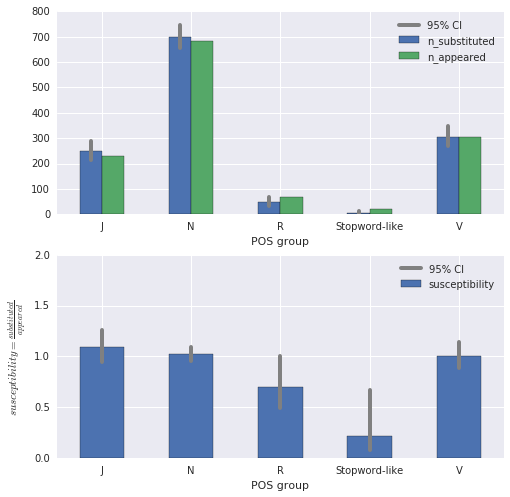

In [8]:
# Compute POS counts.
susties_pos = words[words.feature == 'aoa']\
    .groupby('rPOS')['target']\
    .aggregate({'susceptibility': susty_all,
                'n_substituted': target_all_counts,
                'n_appeared': appeared_all_counts})\
    .rename_axis('POS group')

# Plot.

fig, axes = plt.subplots(2, 1, figsize=(8, 8))
# Raw substituted and appeared values.
susties_pos[['n_substituted', 'n_appeared']]\
    .plot(ax=axes[0], kind='bar', rot=0)
# With their CIs.
total_substituted = susties_pos.n_substituted.sum()
cis = multinomial_proportions_confint(susties_pos.n_substituted.round(),
                                      method='goodman')
for i in range(len(susties_pos)):
    axes[0].plot([i-.125, i-.125], cis[i] * total_substituted,
                 lw=4, color='grey',
                 label='95% CI' if i == 0 else None)
axes[0].legend()
# Substitutability values.
susties_pos['susceptibility']\
    .plot(ax=axes[1], kind='bar', legend=True, ylim=(0, 2), rot=0)
axes[1].set_ylabel(r'$susceptibility = \frac{substituted}{appeared}$')
# With their CIs.
for i in range(len(susties_pos)):
    axes[1].plot([i, i], (cis[i] * total_substituted 
                          / susties_pos.n_appeared.iloc[i]),
                 lw=4, color='grey',
                 label='95% CI' if i == 0 else None)
axes[1].legend(loc='best')
# Save if necessary.
if SAVE_FIGURES:
    fig.savefig(settings.FIGURE.format('all-susceptibilities-pos'),
                bbox_inches='tight', dpi=300)

**Note on confidence intervals**

Here we're in case (3) of the explanation below on confidence intervals (in section 3): it's really like a multinomial sampling, but not quite since not all POS tags are available to sample from in all the sentences. There's no way out of this, so we're going to use multinomial CIs. We can safely scale all the bars and CIs to their respective `n_appeared` values, since that is an independent given before the sampling.

**Are the appeared and substituted proportions statistically different?**

The only test we can easily do is a multinomial goodness-of-fit. This tells us if the `n_substituted` counts are significantly different from the reference `n_appeared` counts.

From there on we know a few things:
* Comparing a given POS's `n_substituted` count to its reference `n_appeared` count tells us if it's statistically different (< or >). We know this will be true individually for any POS that is out of its confidence region for the global goodness-of-fit test, since it's a weaker hypothesis (so the null rejection region will be wider, and the POS we're looking at is already in the rejection region for the global test). We don't know if it'll be true or not for POSes that are in their confidence region for the global test.
* Jointly comparing two POS's `n_substituted` counts to their reference `n_appeared` counts tells us if there is bias for one w.r.t. the other. This is also true for all pairs of POSes that are on alternate sides of their confidence region in the global test (for the same reasons as in the previous point). We don't know if it's true for the other POSes though.

In [9]:
# Test the n_substituted proportions are different from
# the n_appeared proportions
total_appeared = susties_pos.n_appeared.sum()
appeared_cis = multinomial_proportions_confint(
    susties_pos.n_appeared.round(), method='goodman')
differences = [(s < ci[0] * total_appeared) or (s > ci[1] * total_appeared)
               for s, ci in zip(susties_pos.n_substituted, appeared_cis)]
are_different = np.any(differences)
if are_different:
    print("Appeared and substituted proportions are different with p < .05")
    print("The following POS tags are out of their confidence region:",
          list(susties_pos.index[np.where(differences)[0]]))
else:
    print("Appeared and substituted proportions cannot be "
          "said different with p value better than .05")

Appeared and substituted proportions are different with p < .05
The following POS tags are out of their confidence region: ['R', 'Stopword-like']


## 3 On global feature values

Prepare plotting functions, for bin and quartile susceptibilities for each feature.

In [10]:
def print_significance(feature, h0s, heights):
    h0_total = h0s.sum()
    bin_count = len(h0s)
    print()
    print('-' * len(feature))
    print(feature)
    print('-' * len(feature))
    for n_stars, alpha in enumerate([.05, .01, .001]):
        h0_cis = multinomial_proportions_confint(h0s.round(),
                                                 method='goodman',
                                                 alpha=alpha)
        differences = ((heights < h0_cis[:, 0] * h0_total)
                       | (heights > h0_cis[:, 1] * h0_total))
        are_different = np.any(differences)
        stars = ' ' * (3 - n_stars) + '*' * (1 + n_stars)
        if are_different:
            bins_different = np.where(differences)[0]
            bins_different += np.ones_like(bins_different)
            print(stars + ' Target different H_0 with p < {}.'
                  ' Bins [1; {}] out of region: {}'
                  .format(alpha, bin_count, bins_different.tolist()))
        else:
            print('     Target NOT different from H_0 (p > {})'
                  .format(alpha))
            break

In [11]:
def plot_bin_susties(**kwargs):
    data = kwargs['data']
    feature = data.iloc[0].feature
    color = kwargs.get('color', 'blue')
    relative = kwargs.get('relative', False)
    quantiles = kwargs.get('quantiles', False)
    value = data.value_rel if relative else data.value
    
    # Compute binning.
    cut, cut_kws = ((pd.qcut, {}) if quantiles
                    else (pd.cut, {'right': False}))
    for bin_count in range(BIN_COUNT, 0, -1):
        try:
            value_bins, bins = cut(value, bin_count, labels=False,
                                   retbins=True, **cut_kws)
            break
        except ValueError:
            pass
    middles = (bins[:-1] + bins[1:]) / 2

    # Compute bin counts. Note here the bins are computed on the
    # distribution of observed substitutions, not the simulated aggregated
    # distributions of cluster-unit substitutions. But since it's mostly
    # deduplication that the aggregation process addresses, the bins
    # should be mostly the same. This could be corrected by computing
    # bins on the aggregate distribution (not hard), but it's really
    # not important now.
    heights = np.zeros(bin_count)
    h0s = np.zeros(bin_count)
    for i in range(bin_count):
        heights[i] = (data[data.target & (value_bins == i)]
                      .weight_feature.sum())
        h0s[i] = data[value_bins == i].weight_feature_appeared.sum()
    total = sum(heights)
    cis = (multinomial_proportions_confint(heights.round(),
                                           method='goodman')
           * total / h0s[:, np.newaxis])
    
    # Plot them.
    sigmaphi = (r'\sigma_{\phi'
                + ('_r' if relative else '')
                + '}')
    plt.plot(middles, heights / h0s, 
             color=color, label='${}$'.format(sigmaphi))
    plt.fill_between(middles, cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.plot(middles, np.ones_like(middles), '--',
             color=sb.desaturate(color, 0.2),
             label='${}^0$'.format(sigmaphi))
    plt.xlim(middles[0], middles[-1])
    plt.ylim(0, 2)
    
    # Test for statistical significance
    print_significance(feature, h0s, heights)

In [12]:
def plot_grid(data, features, filename,
              plot_function, xlabel, ylabel, plot_kws={}):
    g = sb.FacetGrid(data=data[data['feature']
                               .map(lambda f: f in features)],
                     sharex=False, sharey=True,
                     col='feature', hue='feature',
                     col_order=features, hue_order=features,
                     col_wrap=3, aspect=1.5, size=3)
    g.map_dataframe(plot_function, **plot_kws)
    g.set_titles('{col_name}')
    g.set_xlabels(xlabel)
    g.set_ylabels(ylabel)
    for ax in g.axes.ravel():
        legend = ax.legend(frameon=True, loc='best')
        if not legend:
            # Skip if nothing was plotted on these axes.
            continue
        frame = legend.get_frame()
        frame.set_facecolor('#f2f2f2')
        frame.set_edgecolor('#000000')
        ax.set_title(Substitution._transformed_feature(ax.get_title())
                     .__doc__)
    if SAVE_FIGURES:
        g.fig.savefig(settings.FIGURE.format(filename),
                      bbox_inches='tight', dpi=300)

### 3.1 Bins of distribution of appeared global feature values


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 3]

--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 3]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 3]

---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)

-----------
betweenness
-----------
     Target NOT different from H_0 (p > 0.05)



----------
clustering
----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]

------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2, 3]
     Target NOT different from H_0 (p > 0.001)



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]

--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2]

--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


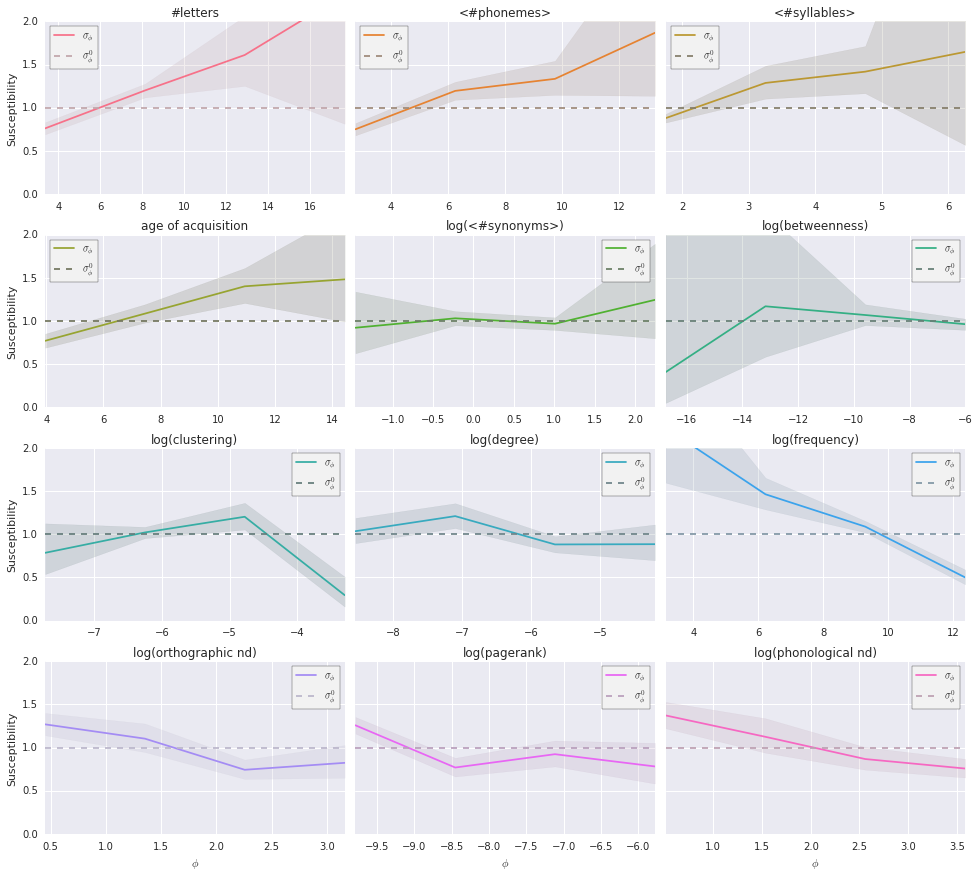

In [13]:
plot_grid(words, ordered_features,
          'all-susceptibilities-fixedbins_global',
          plot_bin_susties, r'$\phi$', 'Susceptibility')

**Note on how graphs and their confidence intervals are computed here**

There are three ways I can do a computation like above:

(1) For each word, we look at how many times it is substituted versus how many times it appears in a position where it could have been substituted. This is the *word*'s susceptibility, $\sigma(w)$. Then for each feature bin $b_i$ we take all the words such that $\phi(w) \in b_i$, average, and compute an asymptotic confidence interval based on how many words are in the bin. This fails for sentence-relative features, because a given word has different feature values depending on the sentence it appears in. So we discard this.

(2) Do the same but at the feature value level. So we define a *feature value* susceptibility, $\sigma_{\phi}(f)$, and compute a confidence interval based on how many different feature values we have in the bin. The idea behind (1) and (2) is to look at the bin middle-value like the relevant object we're measuring, and we have several measures for each bin middle-value, hence the confidence interval. In each bin $b_i$ we have:

$$\left< \sigma_{\phi}(f) \right>_{f \in b_i}$$

The problem with both (1) and (2) is that there's no proper $\mathcal{H}_0$ value, because the averages in the bins don't necessarily equal 1 under $\mathcal{H}_0$. Also, we can't check that there is consistency, showing that the sum of susceptibility values of the bins is 1. Hence case 3:

(3) Consider that we sample a multinomial process: each substitution is in fact the sampling of a feature value from one of the four bins. In that case, we can compute multinomial proportion CIs. This is also not completely satisfactory since in most cases not all feature values are available at the time of sampling, since most sentences don't range over all the feature's values, but it's what lets us compute proper null hypotheses: in each bin $b_i$ we have a value of $\sigma_{\phi}(b_i)$, and the sum of those should be the same under $\mathcal{H}_0$ as in the experiment (in practice in the graphs, we divide by the values under $\mathcal{H}_0$, and the reference is $\sigma_{\phi}^0(b_i) = 1$).

Here and below, we're always in case (3).


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]

---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



----------
clustering
----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]

-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)

--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]


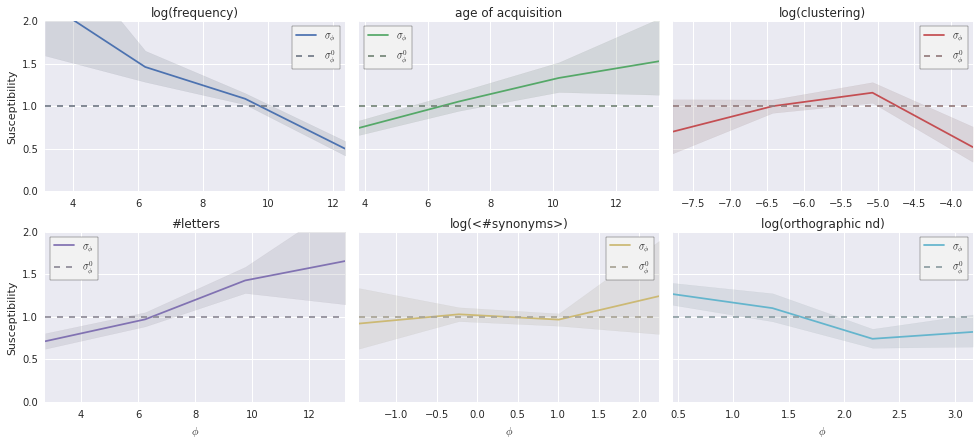

In [14]:
plot_grid(words[~(((words.feature == 'letters_count') 
                   & (words.value > 15))
                  | ((words.feature == 'aoa') 
                     & (words.value > 15))
                  | ((words.feature == 'clustering') 
                     & (words.value > -3)))],
          PAPER_FEATURES,
          'paper-susceptibilities-fixedbins_global',
          plot_bin_susties, r'$\phi$', 'Susceptibility')

### 3.2 Quantiles of distribution of appeared global feature values


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]

--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 2] out of region: [1, 2]
  ** Target different H_0 with p < 0.01. Bins [1; 2] out of region: [1, 2]
 *** Target different H_0 with p < 0.001. Bins [1; 2] out of region: [1, 2]

---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
synonyms_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [4]
     Target NOT different from H_0 (p > 0.001)

-----------
betweenness
-----------
     Target NOT different from H_0 (p > 0.05)



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)

------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2]
     Target NOT different from H_0 (p > 0.001)



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]

--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]

--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


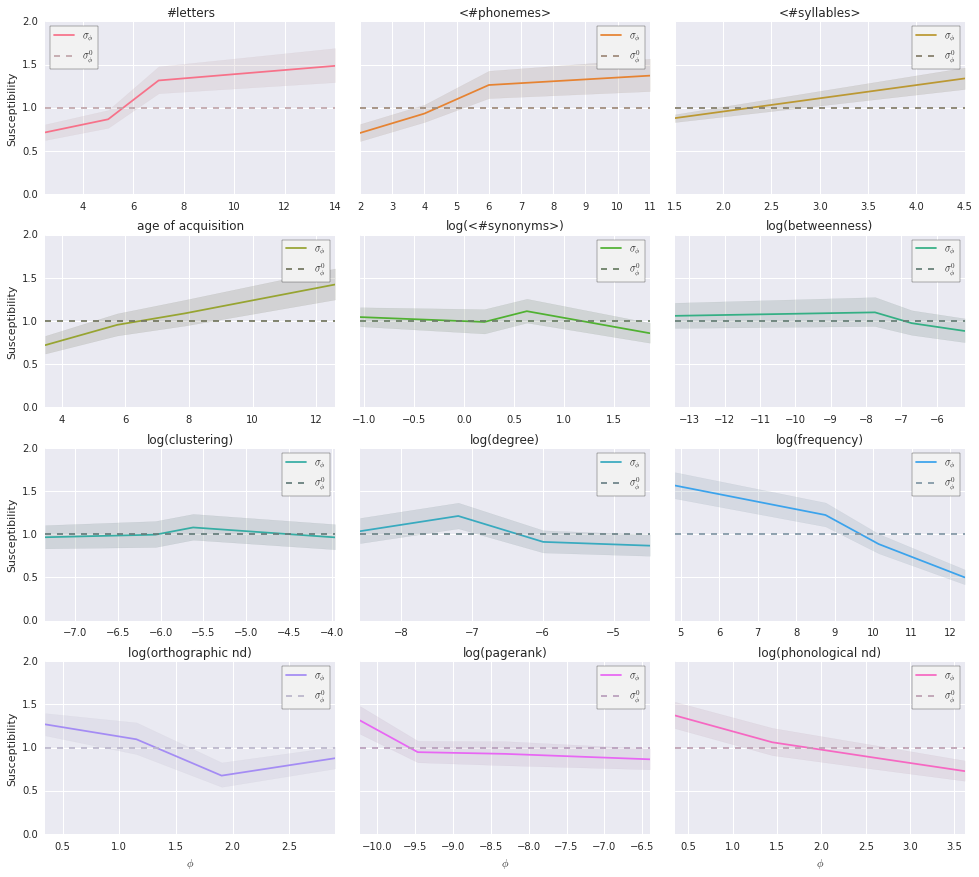

In [15]:
plot_grid(words, ordered_features,
          'all-susceptibilities-quantilebins_global', plot_bin_susties,
          r'$\phi$', 'Susceptibility',
          plot_kws={'quantiles': True})

**Note on confidence intervals**

Here we're again in case (2) of the above explanation on confidence intervals (in section 3.1), since we're just binning by quantiles instead of fixed-width bins.


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]

---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)

-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]



--------------
synonyms_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [4]
     Target NOT different from H_0 (p > 0.001)

--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]


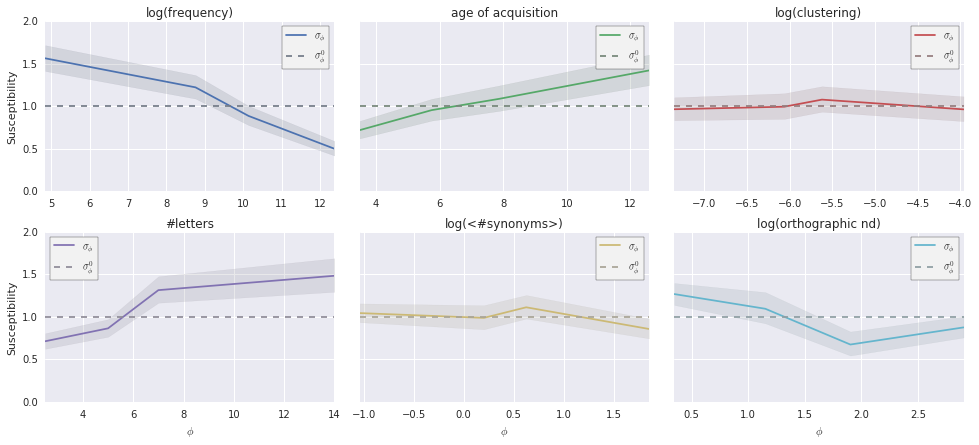

In [16]:
plot_grid(words, PAPER_FEATURES,
          'paper-susceptibilities-quantilebins_global', plot_bin_susties,
          r'$\phi$', 'Susceptibility',
          plot_kws={'quantiles': True})

## 4 On sentence-relative feature values

### 4.1 Bins of distribution of appeared sentence-relative values


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]

--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [2, 3]

---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 3]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)

-----------
betweenness
-----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]



----------
clustering
----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]

------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [3]



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 3, 4]

--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
     Target NOT different from H_0 (p > 0.001)

--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]


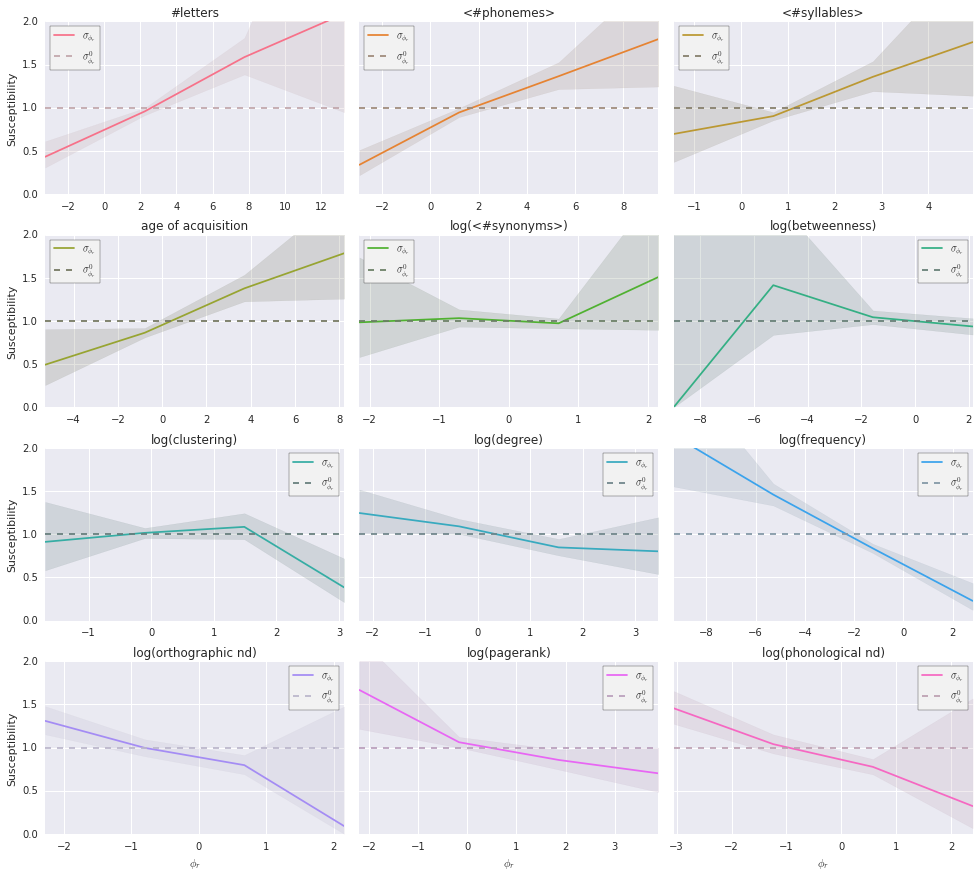

In [17]:
plot_grid(words, ordered_features,
          'all-susceptibilities-fixedbins_sentencerel',
          plot_bin_susties, r'$\phi_r$', 'Susceptibility',
          plot_kws={'relative': True})


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 3, 4]

---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 3]



----------
clustering
----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]

-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)

--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]


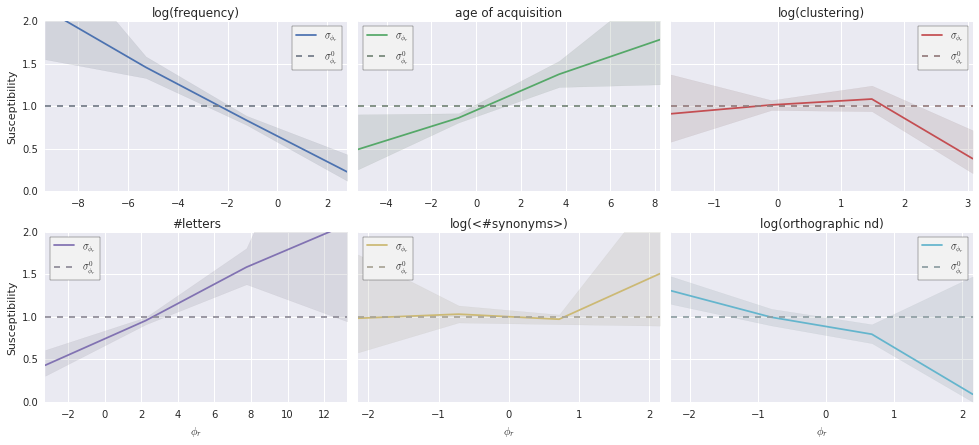

In [18]:
plot_grid(words, PAPER_FEATURES,
          'paper-susceptibilities-fixedbins_sentencerel',
          plot_bin_susties, r'$\phi_r$', 'Susceptibility',
          plot_kws={'relative': True})

### 4.2 Quantiles of distribution of appeared sentence-relative values


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]

--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]

---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)

-----------
betweenness
-----------
     Target NOT different from H_0 (p > 0.05)



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)

------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]

--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]

--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


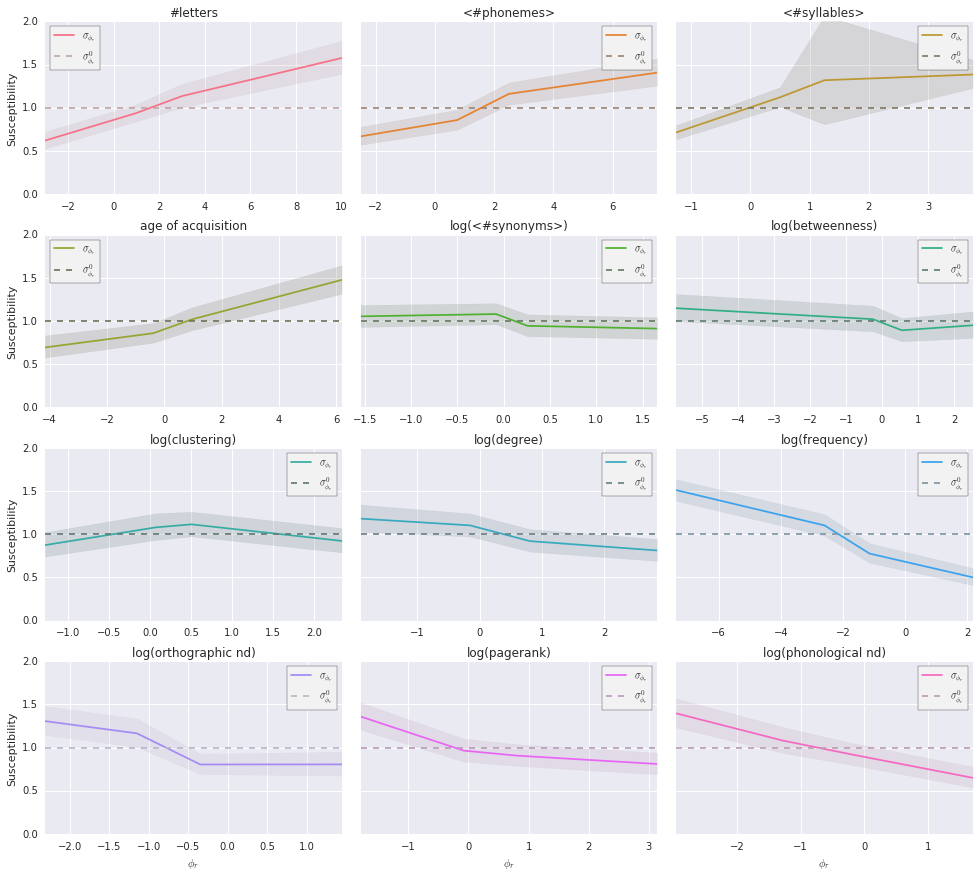

In [19]:
plot_grid(words, ordered_features,
          'all-susceptibilities-quantilebins_sentencerel',
          plot_bin_susties, r'$\phi_r$', 'Susceptibility',
          plot_kws={'quantiles': True, 'relative': True})


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]

---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)

-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)

--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]


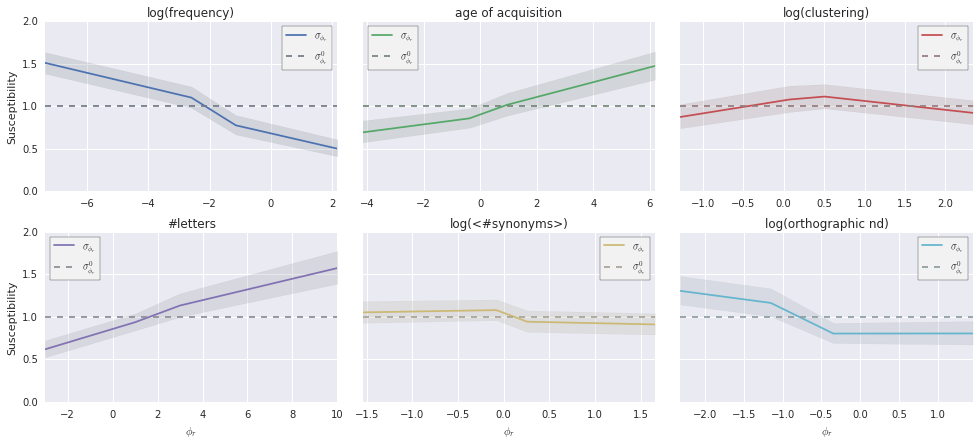

In [20]:
plot_grid(words, PAPER_FEATURES,
          'paper-susceptibilities-quantilebins_sentencerel',
          plot_bin_susties, r'$\phi_r$', 'Susceptibility',
          plot_kws={'quantiles': True, 'relative': True})

## 5 On quantiles and bins of the in-sentence distributions

### 5.1 In-sentence bins (of distribution of values in each sentence)

In [21]:
def plot_sentencebin_susties(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')
    feature = data.iloc[0].feature
    
    # Compute bin counts
    heights = np.zeros(BIN_COUNT)
    h0s = np.zeros(BIN_COUNT)
    for i in range(BIN_COUNT):
        heights[i] = (data[data.target & (data.bin == i)]
                      .weight_feature.sum())
        h0s[i] = data[data.bin == i].weight_feature_appeared.sum()
    total = sum(heights)
    cis = (multinomial_proportions_confint(heights.round(),
                                           method='goodman')
           * total / h0s[:, np.newaxis])
    
    # Plot them.
    sigmaphi = r'\sigma_{bin_{\phi}}'
    x = range(1, BIN_COUNT + 1)
    plt.plot(x, heights / h0s, color=color, label='${}$'.format(sigmaphi))
    plt.fill_between(x, cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.plot(x, np.ones_like(x), '--',
             color=sb.desaturate(color, 0.2),
             label='${}^0$'.format(sigmaphi))
    plt.xticks(x)
    plt.ylim(0, None)
    
    # Test for significance.
    print_significance(feature, h0s, heights)


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]

--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]

---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)

-----------
betweenness
-----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
     Target NOT different from H_0 (p > 0.01)



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)

------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]

--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]

--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


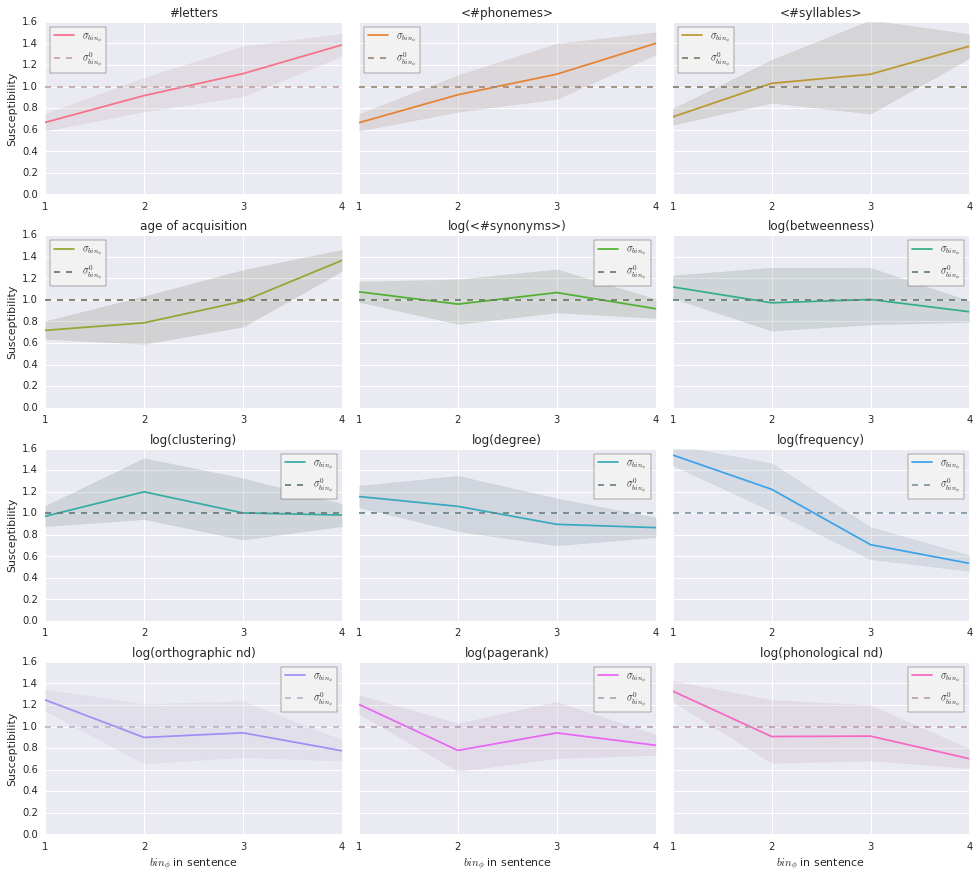

In [22]:
plot_grid(words, ordered_features,
          'all-susceptibilities-sentencebins',
          plot_sentencebin_susties, r'$bin_{\phi}$ in sentence',
          'Susceptibility')


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]

---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)

-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)

--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


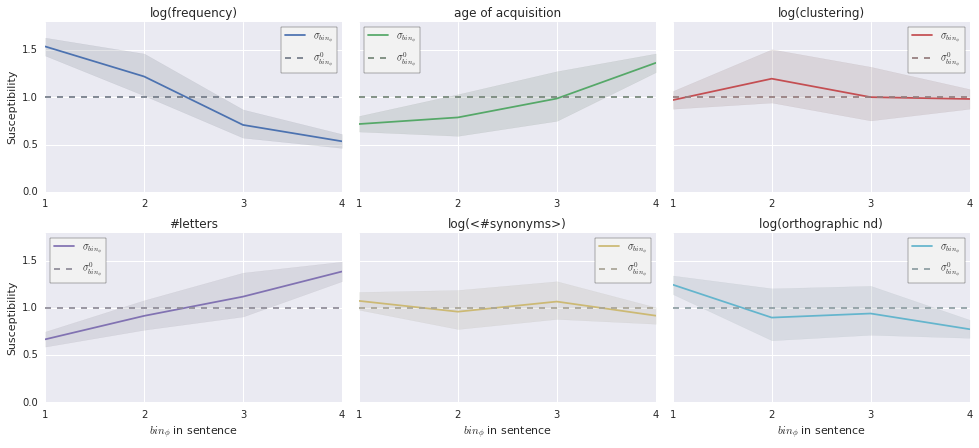

In [23]:
plot_grid(words, PAPER_FEATURES,
          'paper-susceptibilities-sentencebins',
          plot_sentencebin_susties, r'$bin_{\phi}$ in sentence',
          'Susceptibility')

### 5.2 In-sentence quantiles (of distribution of values in each sentence)

For each feature, count the sum of weights in each bin and plot that.

In [24]:
def bound(limits, values):
    left, right = limits
    assert left < right
    return np.maximum(left, np.minimum(right, values))

In [25]:
def plot_sentencequantile_susties(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')
    feature = data.iloc[0].feature
    
    # Compute bin counts
    heights = np.zeros(BIN_COUNT)
    h0s = np.zeros(BIN_COUNT)
    step = 1 / BIN_COUNT
    for i in range(BIN_COUNT):
        limits = [i * step, (i + 1) * step]
        contributions = ((bound(limits, data.stop_quantile)
                          - bound(limits, data.start_quantile))
                         / (data.stop_quantile - data.start_quantile))
        heights[i] = \
            (contributions * data.weight_feature)[data.target].sum()
        h0s[i] = (contributions * data.weight_feature_appeared).sum()
    total = sum(heights)
    cis = (multinomial_proportions_confint(heights.round(),
                                           method='goodman')
           * total)# / h0s[:, np.newaxis])
    
    # Plot them.
    sigmaphi = r'\sigma_{q_{\phi}}'
    x = range(1, BIN_COUNT + 1)
    plt.plot(x, heights,# / h0s,
             color=color, label='${}$'.format(sigmaphi))
    plt.fill_between(x, cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.plot(x, h0s, '--',
             color=sb.desaturate(color, 0.2),
             label='${}^0$'.format(sigmaphi))
    plt.xticks(x)
    plt.ylim(0, None)
    
    # Test for significance.
    print_significance(feature, h0s, heights)


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]

--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]

---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)

-----------
betweenness
-----------
     Target NOT different from H_0 (p > 0.05)



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)

------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [4]
     Target NOT different from H_0 (p > 0.001)



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 3, 4]

--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]

--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


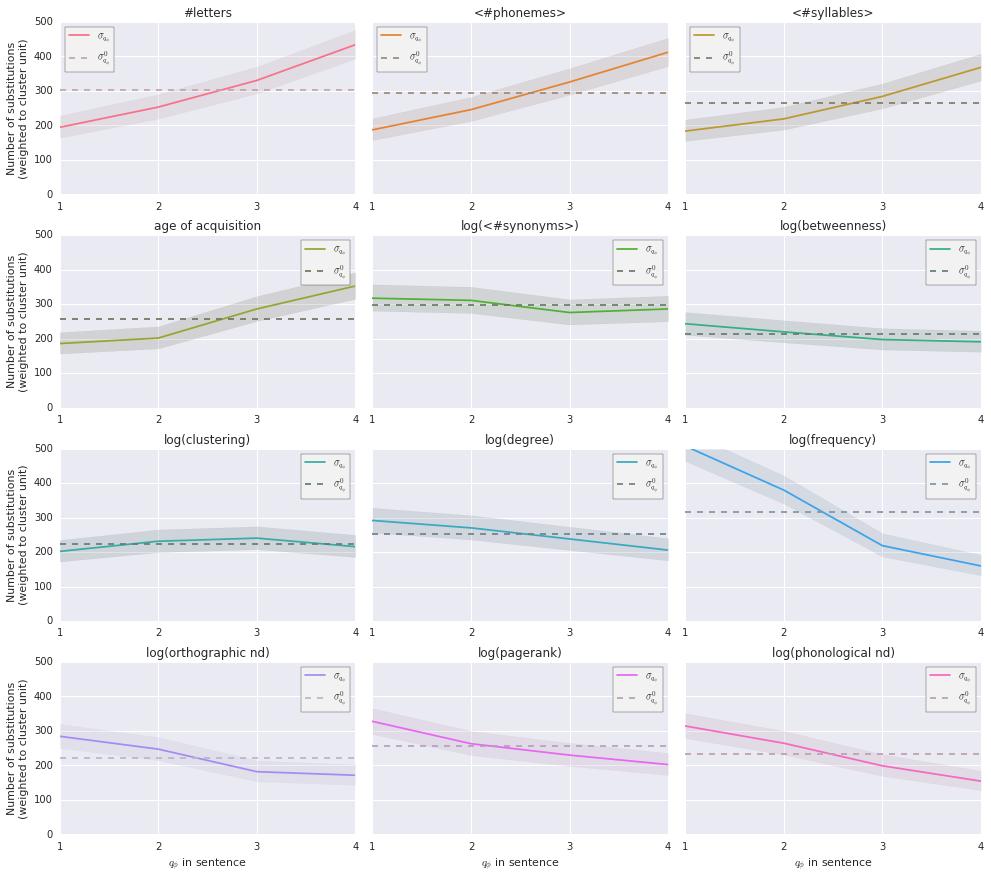

In [26]:
plot_grid(words, ordered_features,
          'all-susceptibilities-sentencequantiles',
          plot_sentencequantile_susties, r'$q_{\phi}$ in sentence',
          'Number of substitutions\n(weighted to cluster unit)')


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 3, 4]

---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)

-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)

--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


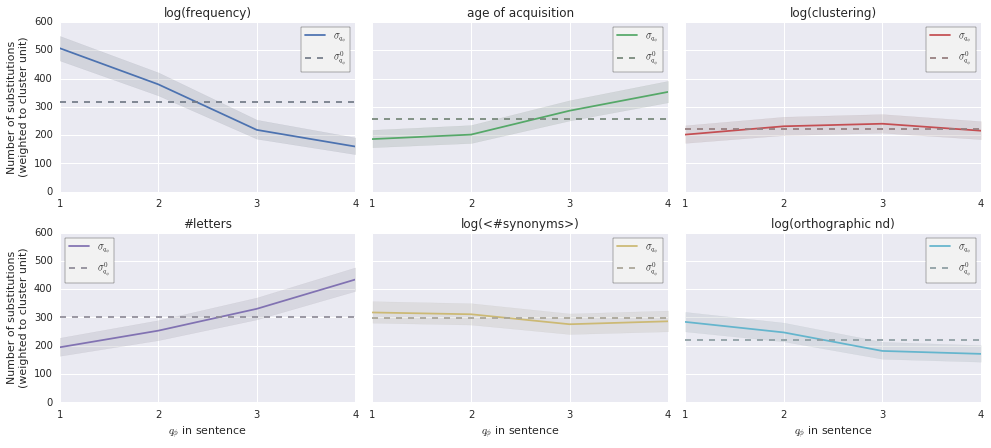

In [27]:
plot_grid(words, PAPER_FEATURES,
          'paper-susceptibilities-sentencequantiles',
          plot_sentencequantile_susties, r'$q_{\phi}$ in sentence',
          'Number of substitutions\n(weighted to cluster unit)')

## 6 Regression on significant features

### 6.1 Multinomial logistic regression

We try to predict which words are substituted, based on their global values, sentence-relative values, bins and quantiles of those, or in-sentence bin values.

Prediction is not good, mainly because the constraint of one-substitution-per-sentence can't be factored in the model simply. So precision is generally very low, around .20-.25, and when accuracy goes up recall plummets.

So it might show some interaction effects, but given that the fit is very bad I wouldn't trust it.

In-sentence quantiles (from section 5.2) were not done, as they're impossible to reduce to one value (our measure of those quantiles is in fact a subrange of [0, 1] for each word, corresponding to the subrange of the sentence distribution that that word's feature value represented).

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import binom_test

In [29]:
def regress_binning(data, features, value_funcs):
    # Compute bins
    data = data.copy()
    regress_features = [('{}'.format(value_name), feature)
                        for value_name in value_funcs.keys()
                        for feature in features]
    for i, (value_name, value_func) in enumerate(value_funcs.items()):
        data[value_name] = value_func(data)
    
    # Massage the dataframe to have feature bin as columns.
    data_wide = pd.pivot_table(
        data,
        values=list(value_funcs.keys()),
        index=['destination_id', 'occurrence', 'source_id', 'position',
               'word_position'],
        columns=['feature']
    )[regress_features]

    # Add the target value.
    # Question/FIXME: should we use weight_appeared for regression?
    data_wide['target'] = pd.pivot_table(
        data,
        values=['target'],
        index=['destination_id', 'occurrence', 'source_id', 'position',
               'word_position'],
        columns=['feature']
    )[('target', 'aoa')]
    data_wide = data_wide.dropna()

    # Compute polynomial features.
    poly = PolynomialFeatures(degree=2, interaction_only=True)
    pdata = poly.fit_transform(data_wide[regress_features])
    pregress_features = [' * '.join(['_'.join(regress_features[j])
                                   for j, p in enumerate(powers)
                                   if p > 0]) or 'intercept'
                         for powers in poly.powers_]

    # Divide into two sets.
    print('Regressing with {} word measures (divided into'
          ' training and prediction sets)'
          .format(len(data_wide)))
    pdata_train = pdata[:len(data_wide) // 2]
    target_train = data_wide.iloc[:len(data_wide) // 2].target
    pdata_predict = pdata[len(data_wide) // 2:]
    target_predict = data_wide.iloc[len(data_wide) // 2:].target
    assert len(pdata_train) + len(pdata_predict) == len(data_wide)
    assert len(target_train) + len(target_predict) == len(data_wide)
    
    # Regress
    regressor = LogisticRegression(penalty='l2', class_weight='balanced',
                                   fit_intercept=False)
    regressor.fit(pdata_train, target_train)
    
    # And predict
    prediction = regressor.predict(pdata_predict)
    standard = target_predict.values
    success = prediction == standard
    
    tp = prediction & standard
    tn = (~prediction) & (~standard)
    fp = prediction & (~standard)
    fn = (~prediction) & standard
    
    print()
    print('{:.2f}% of words well predicted (non-random at p = {:.1})'
          .format(100 * success.mean(),
                  binom_test(success.sum(), len(success))))
    print('Precision = {:.2f}'.format(standard[prediction].mean()))
    print('Recall = {:.2f}'.format(prediction[standard].mean()))
    print()
    print('Coefficients:')
    print(pd.Series(index=pregress_features, data=regressor.coef_[0]))

**Global feature value**

In [30]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'global': lambda d: d.value})

Regressing with 30504 word measures (divided into training and prediction sets)



50.15% of words well predicted (non-random at p = 0.7)
Precision = 0.28
Recall = 0.58

Coefficients:
intercept                                             4.028963
global_frequency                                     -0.455663
global_aoa                                           -0.501205
global_letters_count                                  0.161299
global_orthographic_density                          -0.251240
global_frequency * global_aoa                         0.056933
global_frequency * global_letters_count              -0.017684
global_frequency * global_orthographic_density        0.060570
global_aoa * global_letters_count                     0.001593
global_aoa * global_orthographic_density             -0.037445
global_letters_count * global_orthographic_density   -0.014747
dtype: float64


**Sentence-relative feature value**

In [31]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'sentence-rel': lambda d: d.value_rel})

Regressing with 30504 word measures (divided into training and prediction sets)

64.77% of words well predicted (non-random at p = 2e-295)
Precision = 0.38
Recall = 0.57

Coefficients:
intercept                                                        -0.317003
sentence-rel_frequency                                           -0.140389
sentence-rel_aoa                                                  0.070637
sentence-rel_letters_count                                       -0.018827
sentence-rel_orthographic_density                                 0.113182
sentence-rel_frequency * sentence-rel_aoa                         0.027659
sentence-rel_frequency * sentence-rel_letters_count              -0.028478
sentence-rel_frequency * sentence-rel_orthographic_density        0.025387
sentence-rel_aoa * sentence-rel_letters_count                    -0.001221
sentence-rel_aoa * sentence-rel_orthographic_density              0.000549
sentence-rel_letters_count * sentence-rel_orthographic_density   

**Global + sentence-relative feature values**

In [32]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'global': lambda d: d.value,
                 'sentence-rel': lambda d: d.value_rel})

Regressing with 30504 word measures (divided into training and prediction sets)



63.83% of words well predicted (non-random at p = 4e-259)
Precision = 0.37
Recall = 0.54

Coefficients:
intercept                                                          0.292748
sentence-rel_frequency                                            -0.682797
sentence-rel_aoa                                                   0.881173
sentence-rel_letters_count                                        -0.778021
sentence-rel_orthographic_density                                 -1.129586
global_frequency                                                  -0.150677
global_aoa                                                        -0.837868
global_letters_count                                               0.360757
global_orthographic_density                                        1.079164
sentence-rel_frequency * sentence-rel_aoa                         -0.098680
sentence-rel_frequency * sentence-rel_letters_count               -0.076147
sentence-rel_frequency * sentence-rel_orthographic_density 

**(3.1) Bins of distribution of appeared global feature values**

In [33]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'bins-global':
                     lambda d: pd.cut(d.value, BIN_COUNT,
                                      labels=False, right=False)})

Regressing with 30504 word measures (divided into training and prediction sets)

50.51% of words well predicted (non-random at p = 0.2)
Precision = 0.31
Recall = 0.71

Coefficients:
intercept                                                      -0.001787
bins-global_frequency                                          -0.995426
bins-global_aoa                                                 1.176143
bins-global_letters_count                                       0.826524
bins-global_orthographic_density                               -2.093917
bins-global_frequency * bins-global_aoa                         0.518890
bins-global_frequency * bins-global_letters_count              -0.330656
bins-global_frequency * bins-global_orthographic_density        0.067070
bins-global_aoa * bins-global_letters_count                    -0.729111
bins-global_aoa * bins-global_orthographic_density             -0.838984
bins-global_letters_count * bins-global_orthographic_density    1.910442
dtype: float64


**(3.2) Quantiles of distribution of appeared global feature values**

In [34]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'quantiles-global':
                     lambda d: pd.qcut(d.value, BIN_COUNT, labels=False)})

Regressing with 30504 word measures (divided into training and prediction sets)

57.01% of words well predicted (non-random at p = 3e-67)
Precision = 0.33
Recall = 0.62

Coefficients:
intercept                                                                 1.125276
quantiles-global_frequency                                               -0.781870
quantiles-global_aoa                                                      1.581566
quantiles-global_letters_count                                           -0.240255
quantiles-global_orthographic_density                                    -2.492610
quantiles-global_frequency * quantiles-global_aoa                        -0.707793
quantiles-global_frequency * quantiles-global_letters_count               0.352342
quantiles-global_frequency * quantiles-global_orthographic_density        1.727202
quantiles-global_aoa * quantiles-global_letters_count                     0.230620
quantiles-global_aoa * quantiles-global_orthographic_density         

**(4.1) Bins of distribution of appeared sentence-relative values**

In [35]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'bins-sentence-rel':
                     lambda d: pd.cut(d.value_rel, BIN_COUNT,
                                      labels=False, right=False)})

Regressing with 30504 word measures (divided into training and prediction sets)

70.67% of words well predicted (non-random at p = 5e-324)
Precision = 0.39
Recall = 0.22

Coefficients:
intercept                                                                   0.279499
bins-sentence-rel_frequency                                                -0.279471
bins-sentence-rel_aoa                                                       0.068753
bins-sentence-rel_letters_count                                            -0.210205
bins-sentence-rel_orthographic_density                                      0.279499
bins-sentence-rel_frequency * bins-sentence-rel_aoa                        -0.367049
bins-sentence-rel_frequency * bins-sentence-rel_letters_count               0.290192
bins-sentence-rel_frequency * bins-sentence-rel_orthographic_density       -0.279471
bins-sentence-rel_aoa * bins-sentence-rel_letters_count                     0.228992
bins-sentence-rel_aoa * bins-sentence-rel_orthogra

**(4.2) Quantiles of distribution of appeared sentence-relative values**

In [36]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'quantiles-sentence-rel':
                     lambda d: pd.qcut(d.value_rel, BIN_COUNT,
                                       labels=False)})

Regressing with 30504 word measures (divided into training and prediction sets)

49.60% of words well predicted (non-random at p = 0.3)
Precision = 0.30
Recall = 0.68

Coefficients:
intercept                                                                            -0.132321
quantiles-sentence-rel_frequency                                                      0.180549
quantiles-sentence-rel_aoa                                                           -0.236678
quantiles-sentence-rel_letters_count                                                  0.190653
quantiles-sentence-rel_orthographic_density                                          -0.173614
quantiles-sentence-rel_frequency * quantiles-sentence-rel_aoa                         0.090643
quantiles-sentence-rel_frequency * quantiles-sentence-rel_letters_count              -0.344989
quantiles-sentence-rel_frequency * quantiles-sentence-rel_orthographic_density        0.055778
quantiles-sentence-rel_aoa * quantiles-sentence-rel_letter

**(5.1) In-sentence bins (of distribution of values in each sentence)**

In [37]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'in-sentence-bins': lambda d: d.bin})

Regressing with 30504 word measures (divided into training and prediction sets)

67.24% of words well predicted (non-random at p = 5e-324)
Precision = 0.40
Recall = 0.54

Coefficients:
intercept                                                                -0.547329
in-sentence-bins_frequency                                                0.025710
in-sentence-bins_aoa                                                      0.115055
in-sentence-bins_letters_count                                            0.379487
in-sentence-bins_orthographic_density                                     0.316994
in-sentence-bins_frequency * in-sentence-bins_aoa                        -0.086928
in-sentence-bins_frequency * in-sentence-bins_letters_count              -0.164258
in-sentence-bins_frequency * in-sentence-bins_orthographic_density       -0.089415
in-sentence-bins_aoa * in-sentence-bins_letters_count                     0.007024
in-sentence-bins_aoa * in-sentence-bins_orthographic_density        

### 6.2 PCA

We get coefficient values out of the PCA, but I can't figure what to make of them... They reflect the correlations of the features, alright, but beyond that? Some interactions, but there's no clear interpretation of the coefficients and variances explained into interaction strengths.

In [38]:
from sklearn.decomposition import PCA

In [39]:
def pca_values(data, features, value_func):
    data = data.copy()
    data['pca_value'] = value_func(data)
    
    # Prepare dataframe, averaging over shared durl.
    data_wide = pd.pivot_table(
        data[data.target],
        values='pca_value',
        index=['cluster_id', 'destination_id', 'occurrence',
               'position'],
        columns=['feature']
    )[features]
    # ... then over shared clusters, and dropping NaNs.
    data_wide = data_wide\
        .groupby(level='cluster_id')\
        .agg(np.mean)\
        .dropna(how='any')
    print('Computing PCA on {} aggregated word measures'
          .format(len(data_wide)))
    print()
    
    # Compute PCA.
    pca = PCA(n_components='mle')
    pca.fit(data_wide)
    print('Variance explained by first {} components (mle-estimated): {}'
          .format(pca.n_components_, pca.explained_variance_ratio_))
    print()
    print('Components:')
    print(pd.DataFrame(index=data_wide.columns,
                       data=pca.components_.T,
                       columns=['Comp. {}'.format(i)
                                for i in range(pca.n_components_)]))

**PCA of feature value of substituted words**

In [40]:
pca_values(words, ['frequency', 'aoa', 'letters_count'],
           lambda d: d.value)

Computing PCA on 987 aggregated word measures

Variance explained by first 2 components (mle-estimated): [ 0.70875045  0.16643106]

Components:
                Comp. 0   Comp. 1
feature                          
frequency     -0.340703  0.609638
aoa            0.723926 -0.315620
letters_count  0.599877  0.727135


**PCA of sentence-relative value of substituted words**

In [41]:
pca_values(words, ['frequency', 'aoa', 'letters_count'],
           lambda d: d.value_rel)

Computing PCA on 987 aggregated word measures

Variance explained by first 2 components (mle-estimated): [ 0.6365663   0.20360603]

Components:
                Comp. 0   Comp. 1
feature                          
frequency     -0.443162  0.637983
aoa            0.647133 -0.258457
letters_count  0.620344  0.725381
